In [1]:
# 步骤
# 1.检测人脸
# 2.检测关键点
# 3.添加口罩

In [2]:
# 导入包
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
# %matplotlib inline
plt.rcParams['figure.dpi'] = 200

In [3]:
# 获取人脸的68个关键点
# 关键点 检测模型
shape_detector = dlib.shape_predictor('./weights/shape_predictor_68_face_landmarks.dat')

In [5]:
# 读取一张测试图片
img=cv2.imdecode(np.fromfile('./chinese_faces_cleaned/阿宝/阿宝_2.jpg',dtype=np.uint8),-1)

(-0.5, 71.5, 99.5, -0.5)

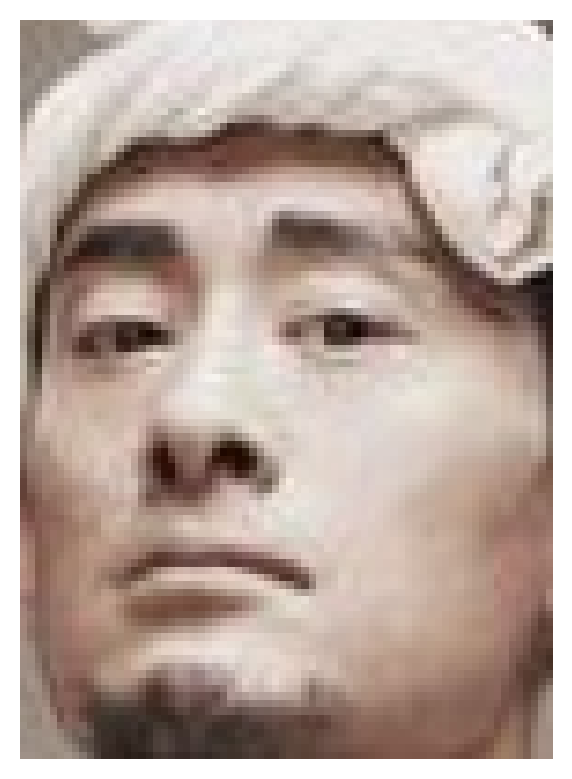

In [6]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis(False)

In [7]:
# 整个裁剪图就是人脸，无需再检测
h,w = img.shape[:2]
l,t,r,b = 0,0,w,h
# 构造DLIB类型
face = dlib.rectangle(l,t,r,b) 
# 获取关键点
points = shape_detector(img,face)

In [8]:
# 复制原图
img_copy = img.copy()

In [9]:
# 绘制关键点
for point in points.parts():
    cv2.circle(img_copy,(point.x,point.y),2,(0,255,0),1)

(-0.5, 71.5, 99.5, -0.5)

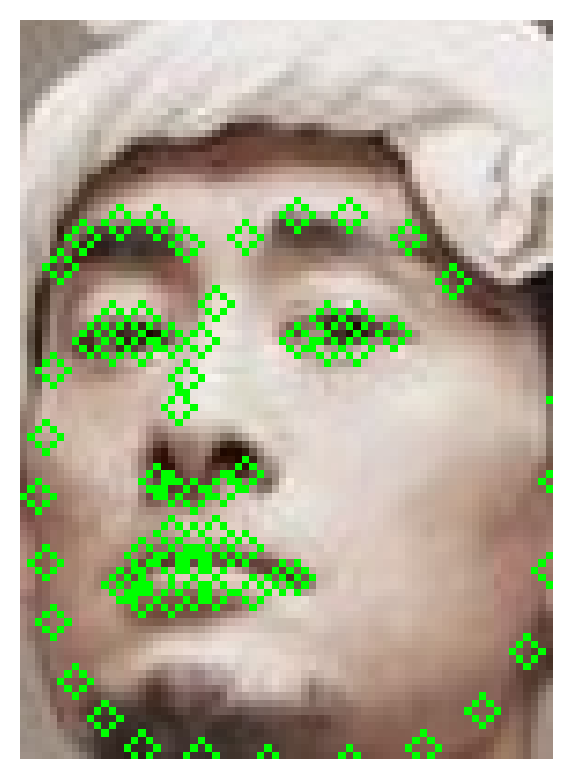

In [10]:
plt.imshow(cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB))
plt.axis(False)

In [12]:
import glob

In [13]:
# 加载口罩图片
mask_list = []

In [14]:
png_list = glob.glob('./images/masks/*.png')

In [15]:
for png_file in png_list:
    mask_img = cv2.imread(png_file)
    mask_list.append(mask_img)

In [16]:
len(mask_list)

14

In [17]:
# 随机挑选一个口罩图片覆盖
import random

In [18]:
def generateMask(image_input, mask_index=-1):
    # 复制图片
    image = image_input.copy()
    if mask_index == -1:
        # 随机选择口罩图
        mask_image = random.choice(mask_list)
    else:
        mask_image = mask_list[mask_index]
    # 获取画面宽度和高度
    (h_i, w_i) = image.shape[:2]
    (h_m, w_m) = mask_image.shape[:2]
    # 构造口罩图片参考平面
    ptsA = np.asarray([[0, 0], [w_m // 2, 0], [w_m, 0], [w_m, h_m], [w_m // 2, h_m], [0, h_m]])
    
    # 获取人脸参考点
    # 整个裁剪图就是人脸，无需再检测
    l,t,r,b = 0,0,w_i,h_i
    # 构造DLIB类型
    face = dlib.rectangle(l,t,r,b) 
    # 获取关键点
    points = shape_detector(img,face)
    points_list = list(points.parts())
    # 左上角、上中、右上角、右下角、下中、左下角
    point_1 = points_list[1].x,points_list[1].y
    point_2 = points_list[28].x,points_list[28].y
    point_3 = points_list[15].x,points_list[15].y
    point_4 = points_list[15].x,points_list[8].y
    point_5 = points_list[8].x,points_list[8].y
    point_6 = points_list[1].x,points_list[8].y
    ptsB = np.asarray([point_1,point_2,point_3,point_4,point_5,point_6])
    # 单应性矩阵
    (H, status) = cv2.findHomography(ptsA, ptsB)
    # 透视
    mask_warped = cv2.warpPerspective(mask_image,H, (w_i, h_i), None,cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)
    
    
    mask_warped = mask_warped.astype(np.uint8)
    
    imask = mask_warped > 1
    image[imask] = mask_warped[imask]
    
    return image.astype(np.uint8)

In [19]:
# 测试

In [21]:
img=cv2.imdecode(np.fromfile('./chinese_faces_cleaned/阿宝/阿宝_2.jpg',dtype=np.uint8),-1)

(-0.5, 71.5, 99.5, -0.5)

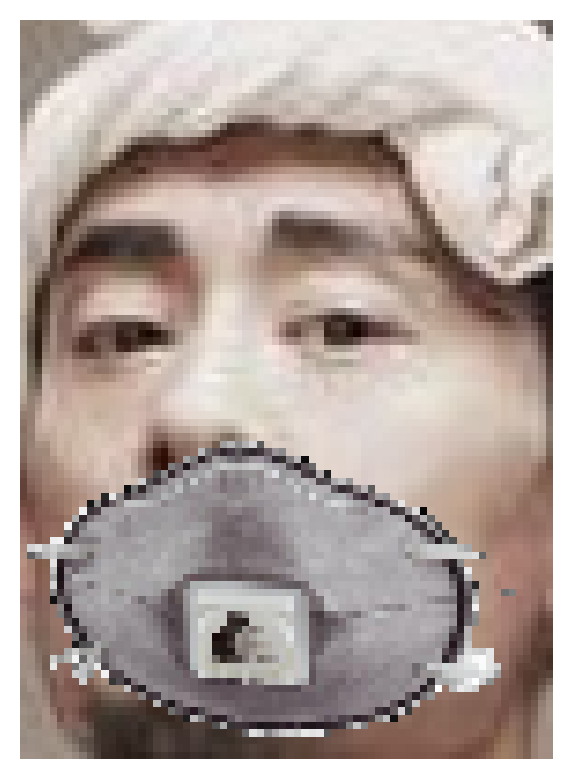

In [22]:
masked_face = generateMask(img,-1)
plt.imshow(cv2.cvtColor(masked_face,cv2.COLOR_BGR2RGB))
plt.axis(False)

In [24]:
img=cv2.imdecode(np.fromfile('./chinese_faces_cleaned/艾伦/艾伦_1.jpg',dtype=np.uint8),-1)

(-0.5, 304.5, 408.5, -0.5)

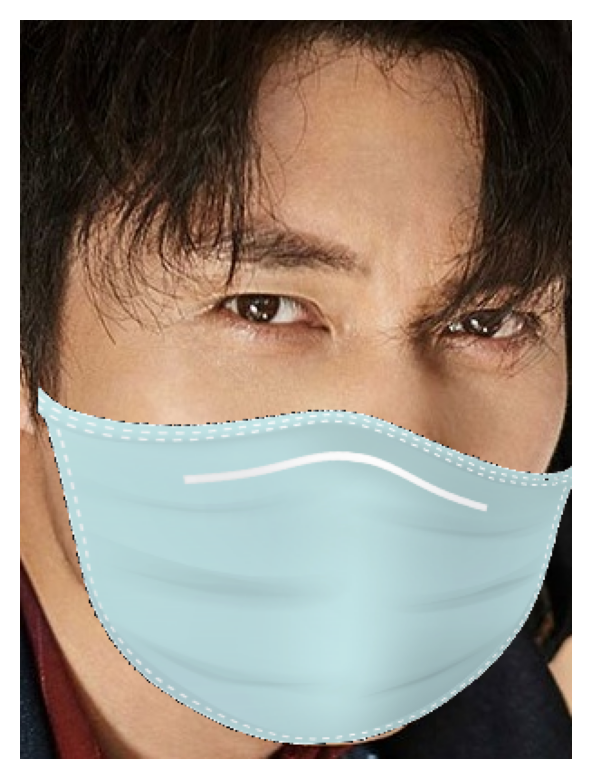

In [25]:
masked_face = generateMask(img,-1)
plt.imshow(cv2.cvtColor(masked_face,cv2.COLOR_BGR2RGB))
plt.axis(False)

In [26]:
import tqdm,os
# 生成口罩图并存储

In [27]:
# 获取所有人名
person_list = glob.glob('./chinese_faces_cleaned/*')

In [28]:
len(person_list)

40

In [29]:
# 遍历每个人的文件夹
for person in tqdm.tqdm(person_list):
    
    # 存入文件夹
    person_class = person.split('\\')[-1]
    # 创建需要保存的目录
    save_dir = './chinese_faces_masked/'+person_class
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # 获取该人名下的所有图片
    file_name = person+'/*.jpg'
    img_list = glob.glob(file_name)
    # 遍历图片
    for img_file in img_list:
        # 获为每一张图添加口罩
        img=cv2.imdecode(np.fromfile(img_file,dtype=np.uint8),-1)
        masked_face = generateMask(img,-1)
        #过滤数据
        if masked_face is not None: 
        
            # 写入
            file_name = img_file.split('\\')[-1]
            save_file_name = save_dir+'/'+file_name
            # 保存，同样要解决中文路径
            # cv2.imwrite(save_file_name,croped_face)
            cv2.imencode('.jpg', masked_face)[1].tofile(save_file_name) 

        
    # break
    
    

100%|██████████| 40/40 [00:01<00:00, 31.05it/s]
